In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
src_path = '/Users/caritsang/Project/1d_AMR/src'

if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import grid
import FVM
import viz
from misc import calc_L1_grid
import problem
import analytical

In [3]:
# Convergence study
reconstruction = ['godunov', 'MUSCL', 'PPM']
temporal_methods = ['RK1', 'RK2', 'RK3']
amr_methods = ['None', 'old', 'new']
bc_type = {'plane': 'periodic', 'sod': 'outflow'}

In [4]:
def evolve(prob, dx_type, dt_type, N, max_level=3, solve_method='None', 
           t_final=0.2, refine_epsilon=0.01, coarse_epsilon=0.005,
           plot=False):

    if solve_method == 'None':
        refine_epsilon = np.inf
        coarse_epsilon = np.inf
        solve_method = 'old'

    grid1 = grid.grid(L=1, N=N)
    grid1_history, init_con = FVM.run_sim(grid1, max_level=max_level, bc_type=bc_type[prob],
                            prob=prob, solve_method=solve_method, 
                            refine_epsilon=refine_epsilon, coarse_epsilon=coarse_epsilon,
                            t_final=t_final, 
                            dt_type=dt_type, dx_type=dx_type)
    
    print(f"Original cell number {N}, Final cell number: {len(grid1.get_all_active_cells())}")

    if plot:
        viz.plot_amr_grid(grid1)
        viz.plot_amr_value(grid1_history[-1], type=prob, init_con=init_con)

    return (calc_L1_grid(grid1, type=prob, init_con=init_con)), len(grid1.get_all_active_cells()), grid1

In [5]:
def error_graph(prob, grid1):

    tmp = grid.grid(grid1.L, grid1.N)
    
    grid1_active = grid1.get_all_active_cells()

    X = np.array([c.x for c in grid1_active])
    prim = np.array([c.prim for c in grid1_active])
    
    if prob == 'sod':
        _, init_con = problem.sod_rod_tube(tmp)
        rho_analytic, u_analytic, P_analytic = analytical.get_sod_solution(X, grid1.t, *init_con)
    elif prob == 'plane':
        _, init_con = problem.plane_wave(tmp)
        rho_analytic, u_analytic, P_analytic = analytical.get_plane_wave_solution(X, grid1.t, *init_con)

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].plot(X, np.abs(rho_analytic - prim[:, 0]))
    ax[0].set_title("Density")
    ax[1].plot(X, np.abs(u_analytic - prim[:, 1]))
    ax[1].set_title("Velocity")
    ax[2].plot(X, np.abs(P_analytic - prim[:, 2]))
    ax[2].set_title("Pressure")

    for axes in ax:
        axes.set_xlabel('X')
        axes.set_ylabel('Absolute error')

    plt.tight_layout()

In [6]:
def compare_L1(prob, N, **kwargs):
    
    MSE = {}
    N_dict = {}
    final_grid = {}

    for amr_method in amr_methods:
        MSE[amr_method] = {}
        final_grid[amr_method] = {}
        N_dict[amr_method] = {}

        for i, method in enumerate(reconstruction[:-1]):
            tmp = []
            tmp2 = []
            for n in N:
                error, final_cells, _ = evolve(prob=prob, dx_type=method, dt_type=temporal_methods[i], N=n, solve_method=amr_method,
                               **kwargs)
                print(f"L1 error: {error}")
                tmp.append(error)
                tmp2.append(final_cells)

            MSE[amr_method][method] = tmp
            final_grid[amr_method][method] = tmp2
            N_dict[amr_method][method] = N

        print('\n')

    return MSE, final_grid, N_dict

Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.5/0.5 [00:00<00:00,  7.80s/s]

FINISHED
Original cell number 30, Final cell number: 30
3.266174838920465e-08


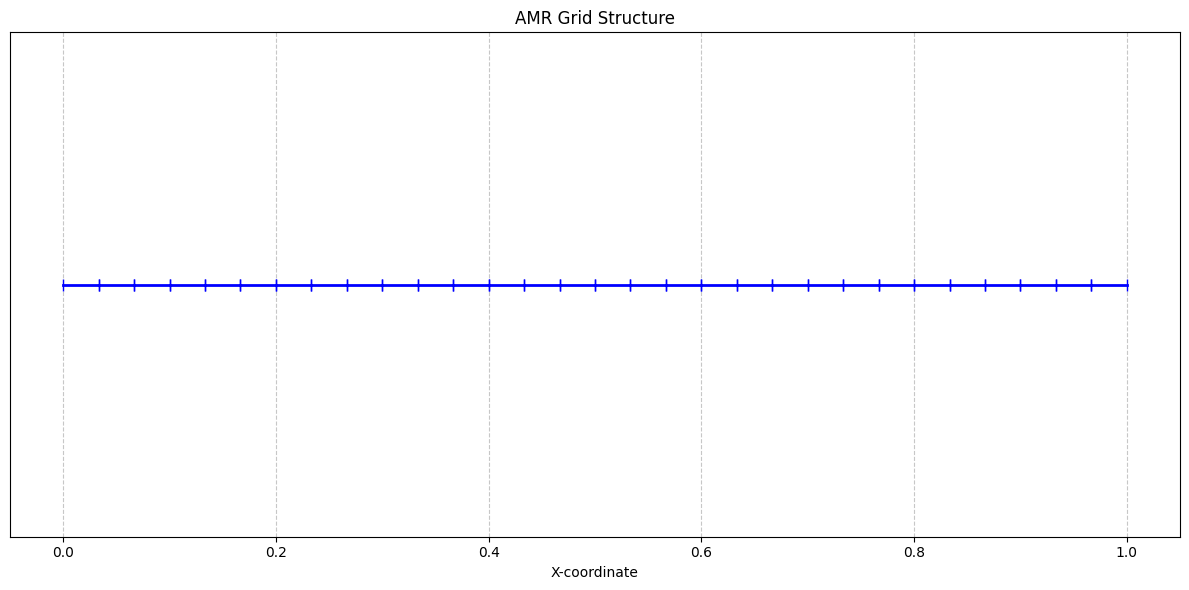

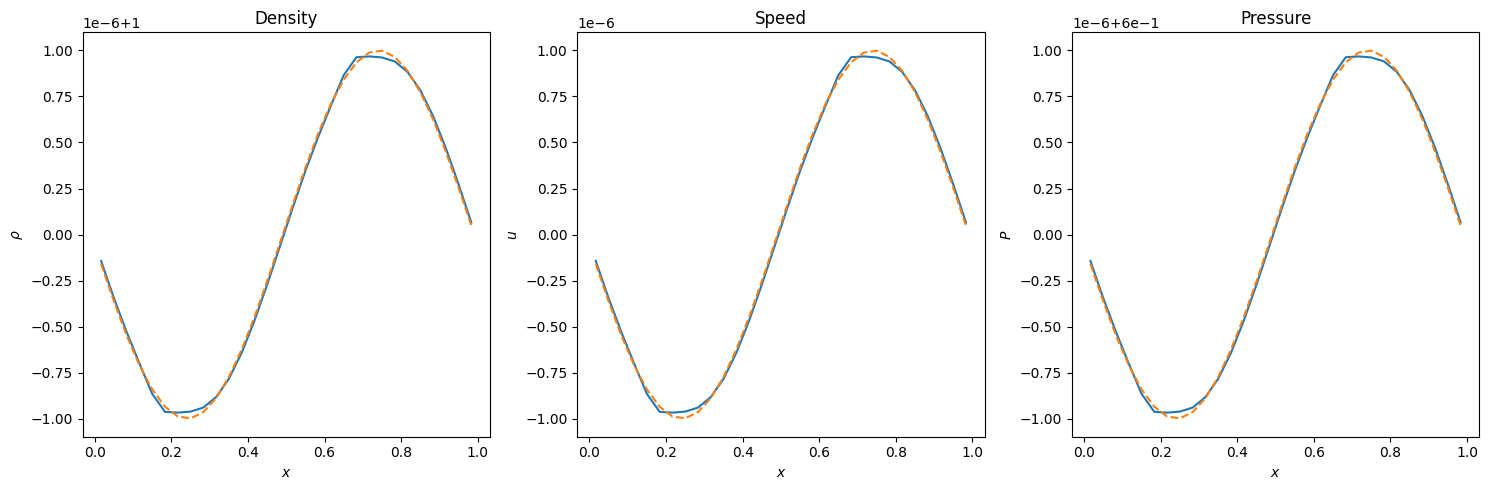

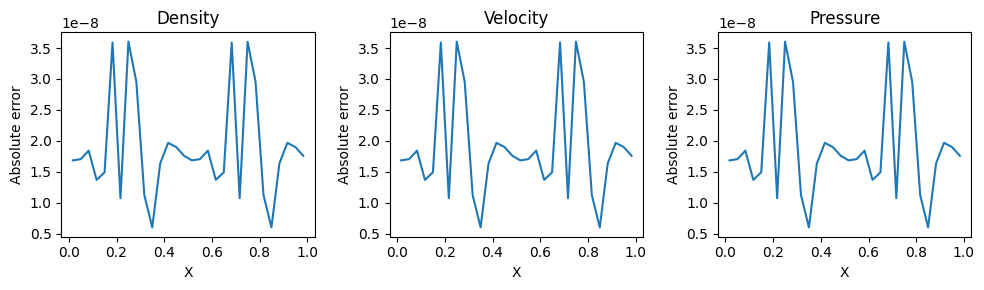

In [141]:
l1, _, grid1 = evolve(prob='plane', dx_type='MUSCL', dt_type='RK2', 
                      N=30, #refine_epsilon=np.inf, coarse_epsilon=np.inf, 
                      solve_method='old', plot=True, t_final=0.5)
error_graph(prob='plane', grid1=grid1)
print(l1)

Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation:   0%|          | 0/0.2 [00:00<?, ?s/s]/Users/caritsang/Project/1d_AMR/src/misc.py:256: RuntimeWarning: invalid value encountered in divide
  d2q_dx2 = 2 * numerator / denominator
Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  5.35s/s]

FINISHED
Original cell number 30, Final cell number: 30


0.09811377403045461


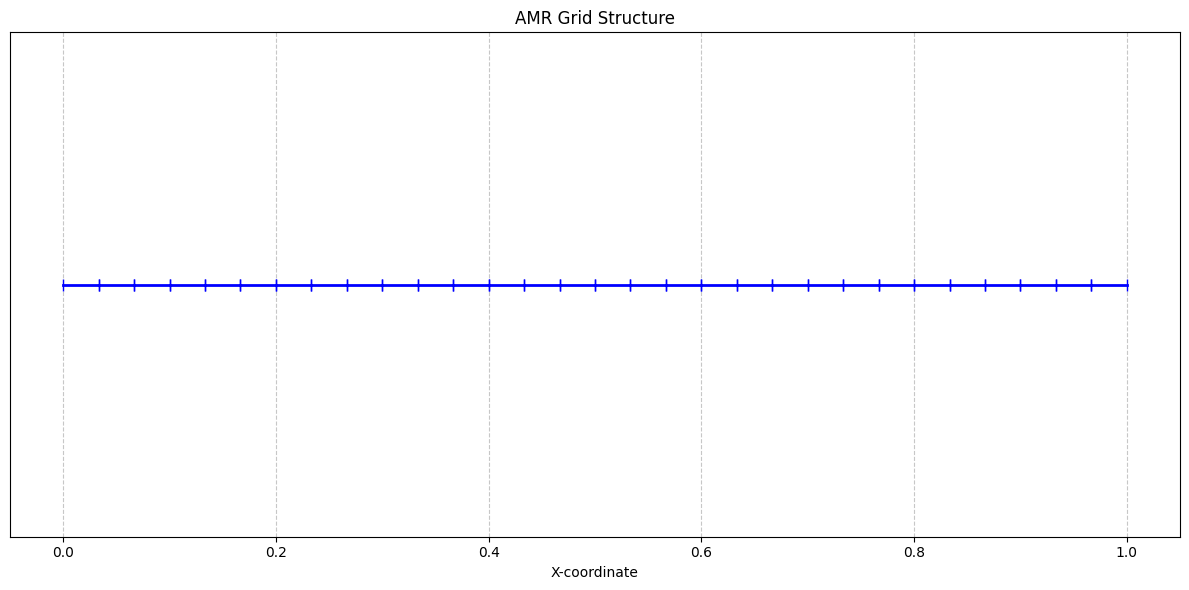

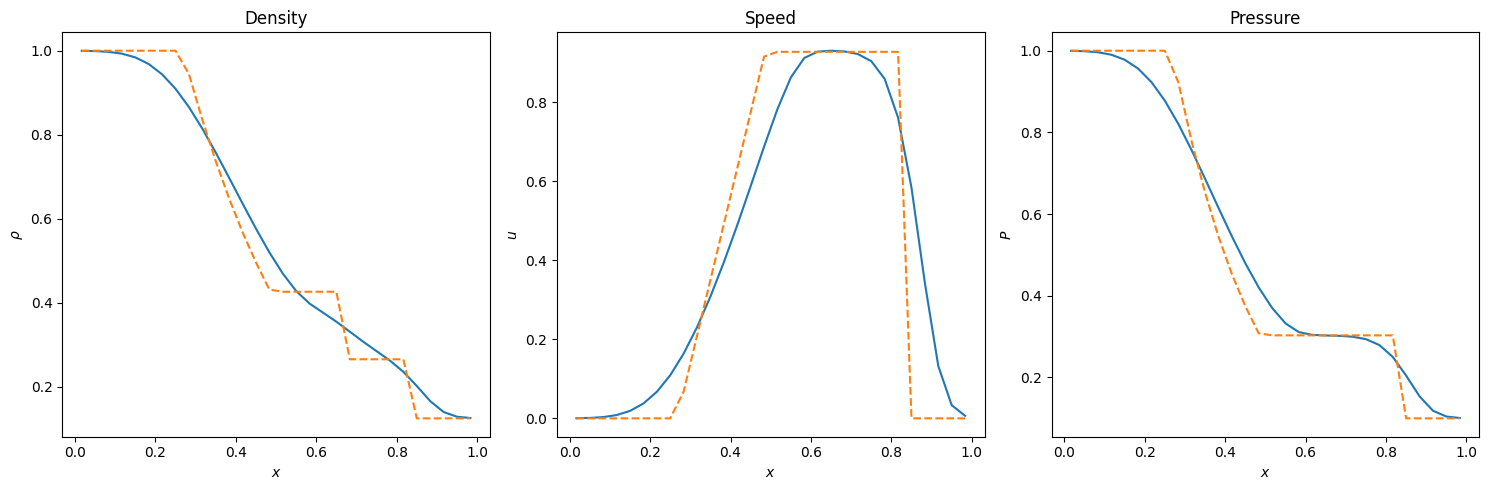

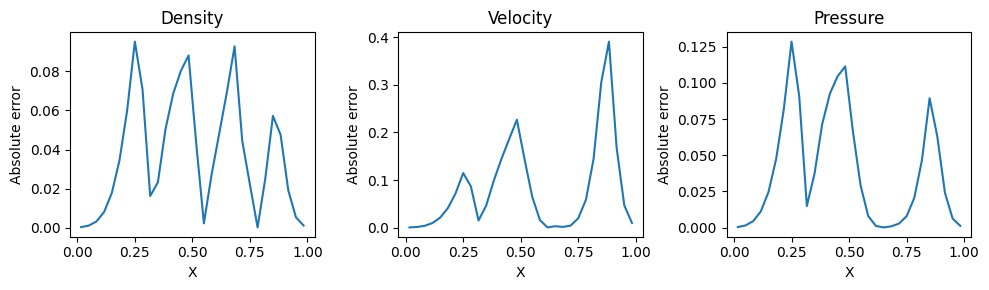

In [ ]:
l1, _, grid1 = evolve(prob='plane', dx_type='godunov', dt_type='RK1', 
                      N=30, 
                      #refine_epsilon=1e-7,
                      #coarse_epsilon=1e-8, 
                      solve_method='None', plot=True, t_final=0.2)
error_graph(prob='sod', grid1=grid1)
print(l1)

Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.05s/s]

FINISHED
Original cell number 30, Final cell number: 30


1.0387056030609415e-07


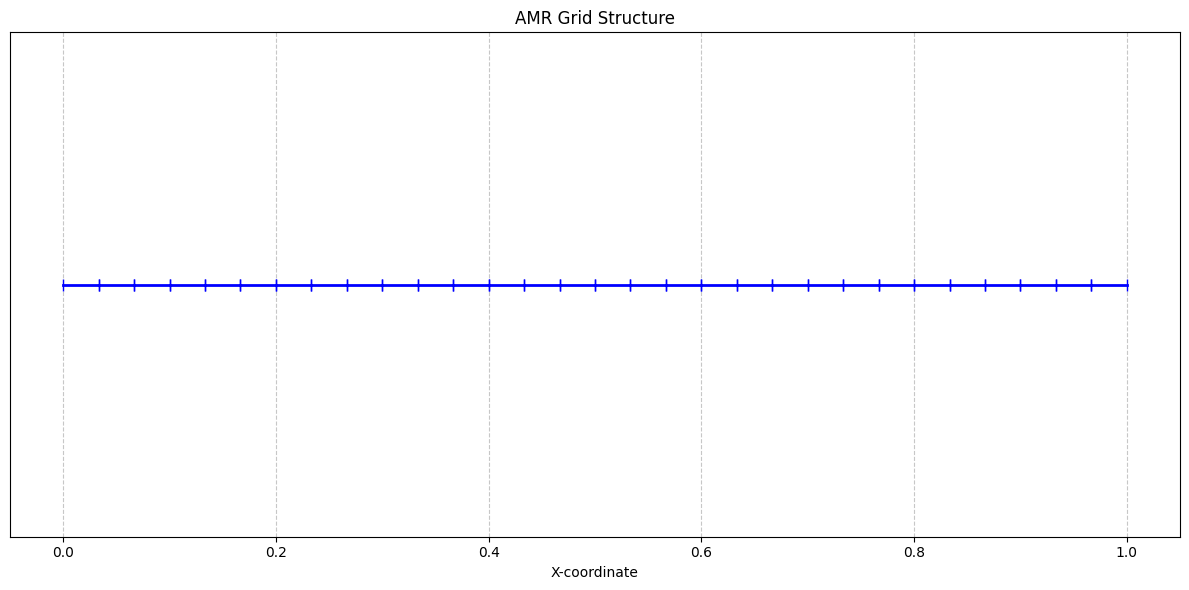

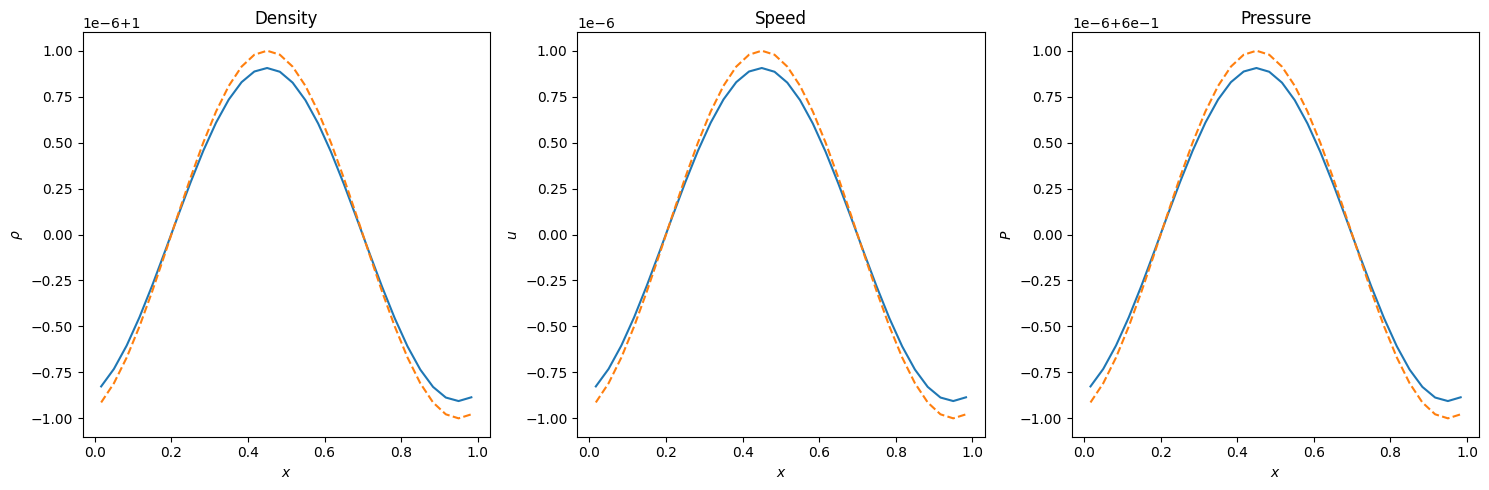

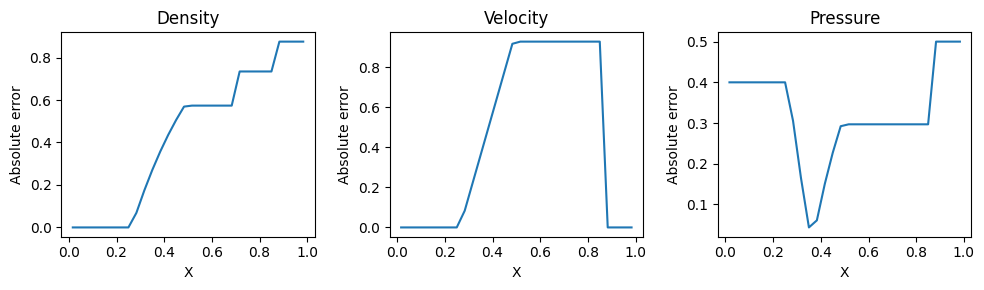

In [173]:
l1, _, grid1 = evolve(prob='plane', dx_type='godunov', dt_type='RK1', 
                      N=30, #refine_epsilon=np.inf, c
                      coarse_epsilon=np.inf, 
                      solve_method='new', plot=True, t_final=0.2)
error_graph(prob='sod', grid1=grid1)
print(l1)

Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:03<00:00, 16.12s/s]                 


FINISHED
Original cell number 150, Final cell number: 150
0.03559614215874083


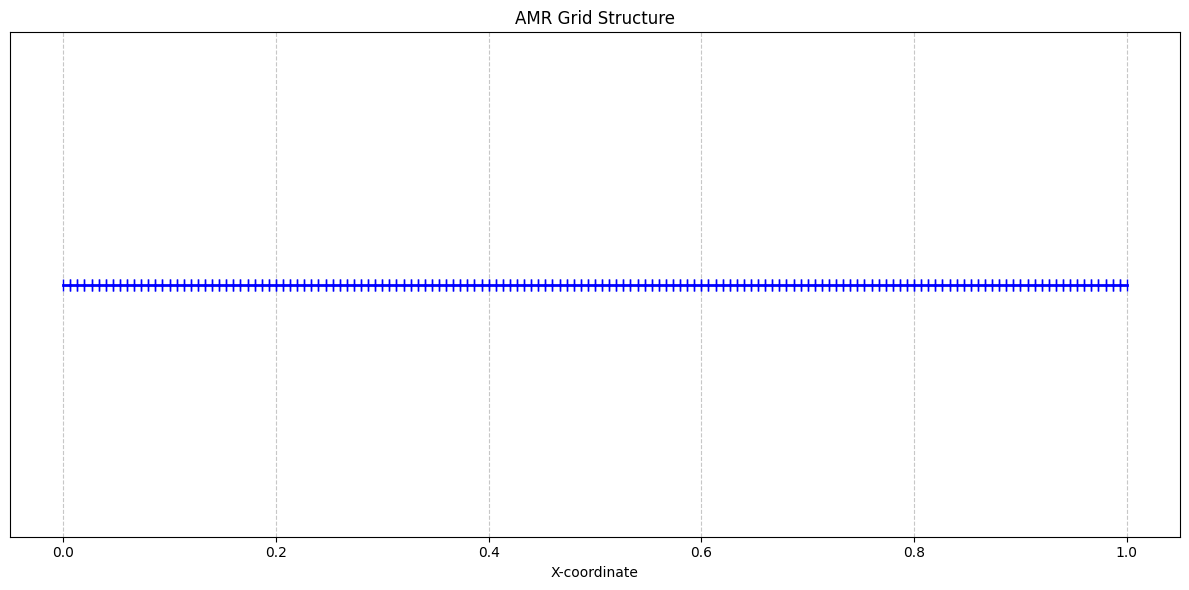

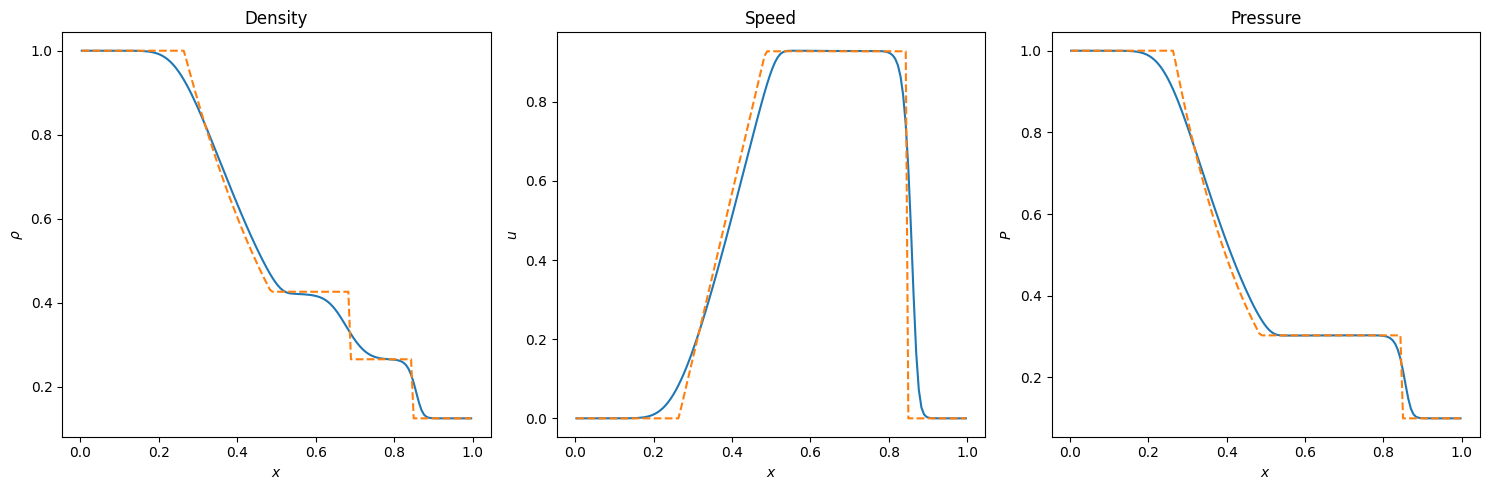

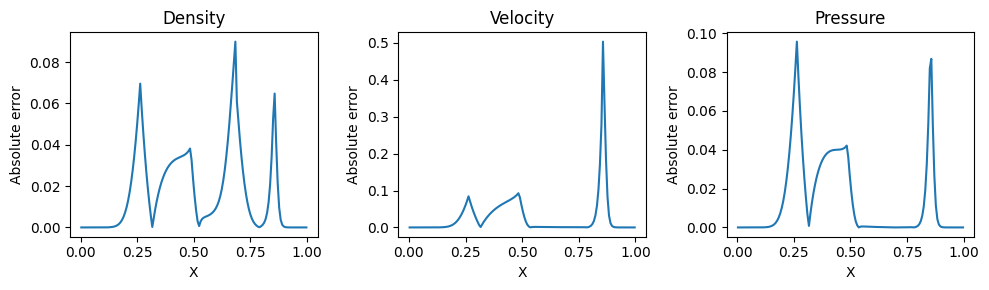

In [103]:
l1, _, grid1 = evolve(prob='sod', dx_type='godunov', dt_type='RK1', 
                      N=150, refine_epsilon=0.1, coarse_epsilon=np.inf, 
                      solve_method='new', plot=True, t_final=0.2)
error_graph(prob='sod', grid1=grid1)
print(l1)

In [162]:
N = [2 ** n for n in range(4, 8)]
sod_MSE, sod_final_gridm, N_dict = compare_L1(prob='sod', N=N, 
                                              #refine_epsilon=np.inf, coarse_epsilon=np.inf
                                              )

Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00, 14.76s/s]


FINISHED
Original cell number 16, Final cell number: 16
L1 error: 0.14279577701104632
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  4.69s/s]


FINISHED
Original cell number 32, Final cell number: 32
L1 error: 0.09931368107328448
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.32s/s]                


FINISHED
Original cell number 64, Final cell number: 64
L1 error: 0.06294844446403497
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.67s/s]                


FINISHED
Original cell number 128, Final cell number: 128
L1 error: 0.03628433040716062
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00, 10.92s/s]


FINISHED
Original cell number 16, Final cell number: 16
L1 error: 0.07825485007349169
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  3.12s/s]


FINISHED
Original cell number 32, Final cell number: 32
L1 error: 0.04592901609600241
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.06s/s]                


FINISHED
Original cell number 64, Final cell number: 64
L1 error: 0.026092792169784315
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  4.78s/s]                


FINISHED
Original cell number 128, Final cell number: 128
L1 error: 0.010922652511974587


Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.51s/s]                


FINISHED
Original cell number 16, Final cell number: 82
L1 error: 0.0626199145241005
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  4.76s/s]                 


FINISHED
Original cell number 32, Final cell number: 138
L1 error: 0.03624403762975939
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:03<00:00, 16.29s/s]                 


FINISHED
Original cell number 64, Final cell number: 185
L1 error: 0.02221201191552029
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:09<00:00, 47.87s/s]                 


FINISHED
Original cell number 128, Final cell number: 245
L1 error: 0.015155659883503533
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.58s/s]                


FINISHED
Original cell number 16, Final cell number: 75
L1 error: 0.04322901009221551
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  7.44s/s]                 


FINISHED
Original cell number 32, Final cell number: 67
L1 error: 0.020408464548537248
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:03<00:00, 18.21s/s]                 


FINISHED
Original cell number 64, Final cell number: 94
L1 error: 0.010751912856220515
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:10<00:00, 51.27s/s]                 


FINISHED
Original cell number 128, Final cell number: 155
L1 error: 0.005163158381831045


Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.93s/s]                


FINISHED
Original cell number 16, Final cell number: 87
L1 error: 0.04411385271043809
Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  6.99s/s]                


FINISHED
Original cell number 32, Final cell number: 146
L1 error: 0.02543036438251335
Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:05<00:00, 27.94s/s]                 


FINISHED
Original cell number 64, Final cell number: 257
L1 error: 0.01500326568705978
Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:21<00:00, 108.29s/s]                


FINISHED
Original cell number 128, Final cell number: 474
L1 error: 0.008623023236925926
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  3.72s/s]                


FINISHED
Original cell number 16, Final cell number: 78
L1 error: 0.022169887261045258
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:03<00:00, 16.61s/s]                 


FINISHED
Original cell number 32, Final cell number: 139
L1 error: 0.011112673681759073
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:17<00:00, 89.78s/s]                  


FINISHED
Original cell number 64, Final cell number: 257
L1 error: 0.006089339759986977
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [01:46<00:00, 533.18s/s]                  


FINISHED
Original cell number 128, Final cell number: 489
L1 error: 0.002754302116440852




In [163]:
plane_MSE, plane_final_grid, N_dict = compare_L1(prob='plane', N=N, 
                                                 refine_epsilon=1e-7, coarse_epsilon=1e-8
                                                 )

Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00, 24.76s/s]


FINISHED
Original cell number 16, Final cell number: 16
L1 error: 1.3357111908703635e-07
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  8.75s/s]


FINISHED
Original cell number 32, Final cell number: 32
L1 error: 6.676061634259398e-08
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.56s/s]


FINISHED
Original cell number 64, Final cell number: 64
L1 error: 3.3819276635323046e-08
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.22s/s]                


FINISHED
Original cell number 128, Final cell number: 128
L1 error: 1.6926417078907246e-08
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00, 20.11s/s]


FINISHED
Original cell number 16, Final cell number: 16
L1 error: 4.687878649541956e-08
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  5.90s/s]


FINISHED
Original cell number 32, Final cell number: 32
L1 error: 1.2880160279963065e-08
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.74s/s]               


FINISHED
Original cell number 64, Final cell number: 64
L1 error: 3.436104297433091e-09
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.89s/s]                 


FINISHED
Original cell number 128, Final cell number: 128
L1 error: 8.628005844592531e-10


Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.34s/s]                


FINISHED
Original cell number 16, Final cell number: 80
L1 error: 7.177292426059301e-08
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  9.76s/s]


FINISHED
Original cell number 32, Final cell number: 32
L1 error: 6.676061634259398e-08
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.76s/s]


FINISHED
Original cell number 64, Final cell number: 64
L1 error: 3.3819276635323046e-08
Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.16s/s]                


FINISHED
Original cell number 128, Final cell number: 128
L1 error: 1.6926417078907246e-08
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  3.20s/s]


FINISHED
Original cell number 16, Final cell number: 39
L1 error: 2.9224052831909483e-08
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.94s/s]


FINISHED
Original cell number 32, Final cell number: 34
L1 error: 1.1197138892896013e-08
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.89s/s]                


FINISHED
Original cell number 64, Final cell number: 64
L1 error: 3.436104297433091e-09
Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.00s/s]                


FINISHED
Original cell number 128, Final cell number: 128
L1 error: 8.628005844592531e-10


Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.52s/s]                


FINISHED
Original cell number 16, Final cell number: 124
L1 error: 2.835003159090562e-08
Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  5.96s/s]                 


FINISHED
Original cell number 32, Final cell number: 240
L1 error: 1.1386768102080584e-08
Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:05<00:00, 26.85s/s]                 


FINISHED
Original cell number 64, Final cell number: 466
L1 error: 5.694514239967696e-09
Using new method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:21<00:00, 105.20s/s]                 


FINISHED
Original cell number 128, Final cell number: 860
L1 error: 5.864177926213955e-09
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.36s/s]                


FINISHED
Original cell number 16, Final cell number: 118
L1 error: 1.2775092377650753e-08
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:02<00:00, 10.07s/s]                 


FINISHED
Original cell number 32, Final cell number: 242
L1 error: 2.525807419555589e-09
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:11<00:00, 58.26s/s]                 


FINISHED
Original cell number 64, Final cell number: 474
L1 error: 5.668596216839154e-10
Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation:  13%|█▎        | 0.02539059156254052/0.2 [00:09<01:02, 359.11s/s]  


KeyboardInterrupt: 

In [110]:
colormap = {'new': 'b',
            'old': 'g',
            'None': 'r'}

linestyle_map = {
    'godunov': '-',
    'MUSCL': '--',
    'PPM': ':'
}

In [118]:
def compare(ax, dict_x, dict_y, xlabel=None, ylabel=None, scale='log', title=None, legend=False):
    for amr_method in amr_methods:
        for i, method in enumerate(reconstruction):
            try:
                ax.plot(dict_x[amr_method][method], dict_y[amr_method][method], 
                     label=f'{amr_method} + {method} + {temporal_methods[i]}', 
                     color=colormap[amr_method],
                     linestyle=linestyle_map[method])
            except:
                pass

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    if title is not None:
        ax.set_title(title)
        
    if legend:
        ax.legend(frameon=False, bbox_to_anchor=(1.08, 0.6))
    ax.set_xscale(scale)
    ax.set_yscale(scale)

Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.60s/s]                


FINISHED
Original cell number 100, Final cell number: 100


(0.012038233305131905,
 100,
 (L=1, N=100, dx={0: 0.01}, grid={0: Cell(prim=[1. 0. 1.], xmin=0.000, xmax=0.010, id=0, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 1: Cell(prim=[1. 0. 1.], xmin=0.010, xmax=0.020, id=1, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 2: Cell(prim=[1. 0. 1.], xmin=0.020, xmax=0.030, id=2, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 3: Cell(prim=[1. 0. 1.], xmin=0.030, xmax=0.040, id=3, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 4: Cell(prim=[1. 0. 1.], xmin=0.040, xmax=0.050, id=4, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 5: Cell(prim=[1. 0. 1.], xmin=0.050, xmax=0.060, id=5, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 6: Cell(prim=[1. 0. 1.], xmin=0.060, xmax=0.070, id=6, childr

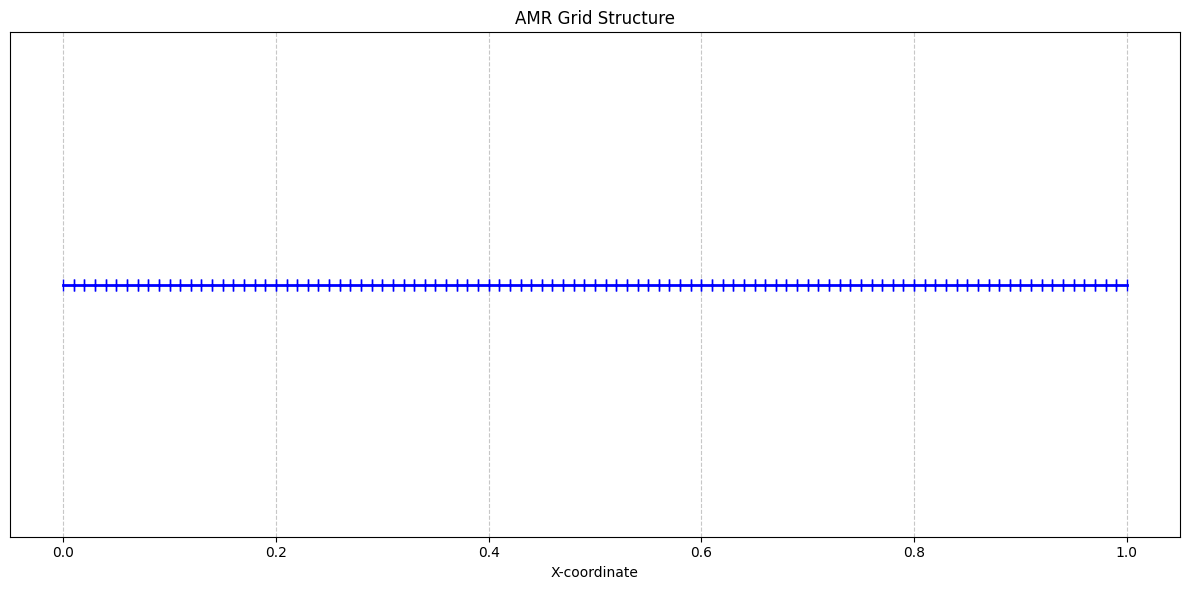

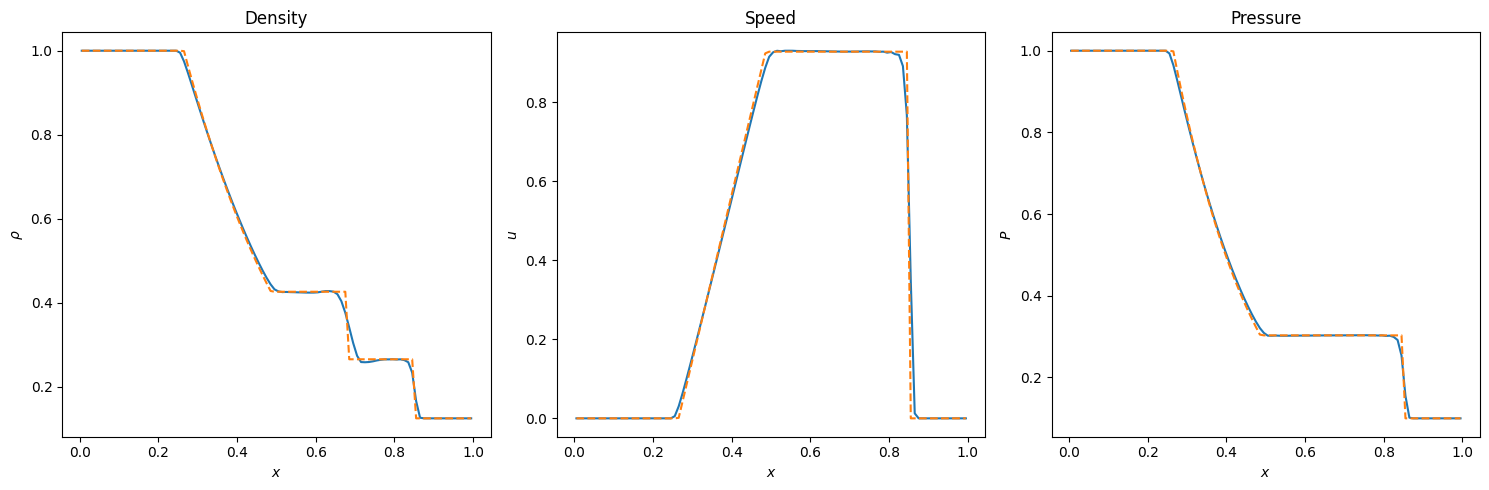

In [127]:
evolve(prob='sod', dx_type='MUSCL', dt_type='RK2', N=100, refine_epsilon=np.inf, coarse_epsilon=np.inf, solve_method='None', plot=True)

Using new method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:08<00:00, 43.76s/s]                 

FINISHED
Original cell number 100, Final cell number: 100


(0.009196767315591936,
 100,
 (L=1, N=100, dx={0: 0.01}, grid={0: Cell(prim=[1. 0. 1.], xmin=0.000, xmax=0.010, id=0, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 1: Cell(prim=[1. 0. 1.], xmin=0.010, xmax=0.020, id=1, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 2: Cell(prim=[1. 0. 1.], xmin=0.020, xmax=0.030, id=2, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 3: Cell(prim=[1. 0. 1.], xmin=0.030, xmax=0.040, id=3, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 4: Cell(prim=[1. 0. 1.], xmin=0.040, xmax=0.050, id=4, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 5: Cell(prim=[1. 0. 1.], xmin=0.050, xmax=0.060, id=5, children=[], parent=None, level=0, need_refine=False, need_coarse=False, activating=True), 6: Cell(prim=[1. 0. 1.], xmin=0.060, xmax=0.070, id=6, childr

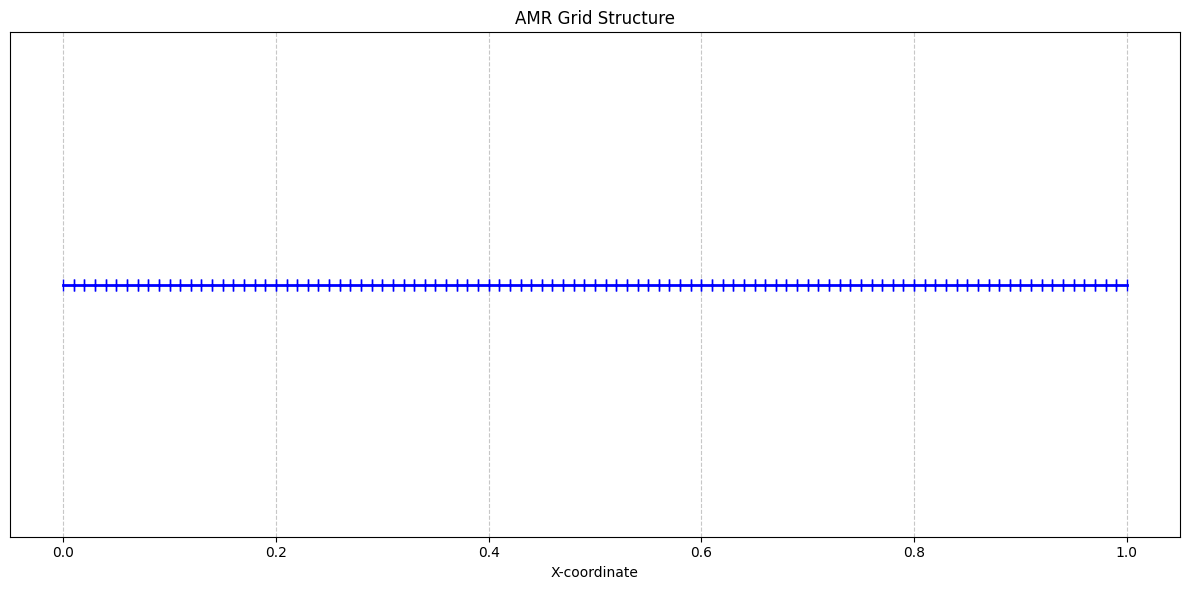

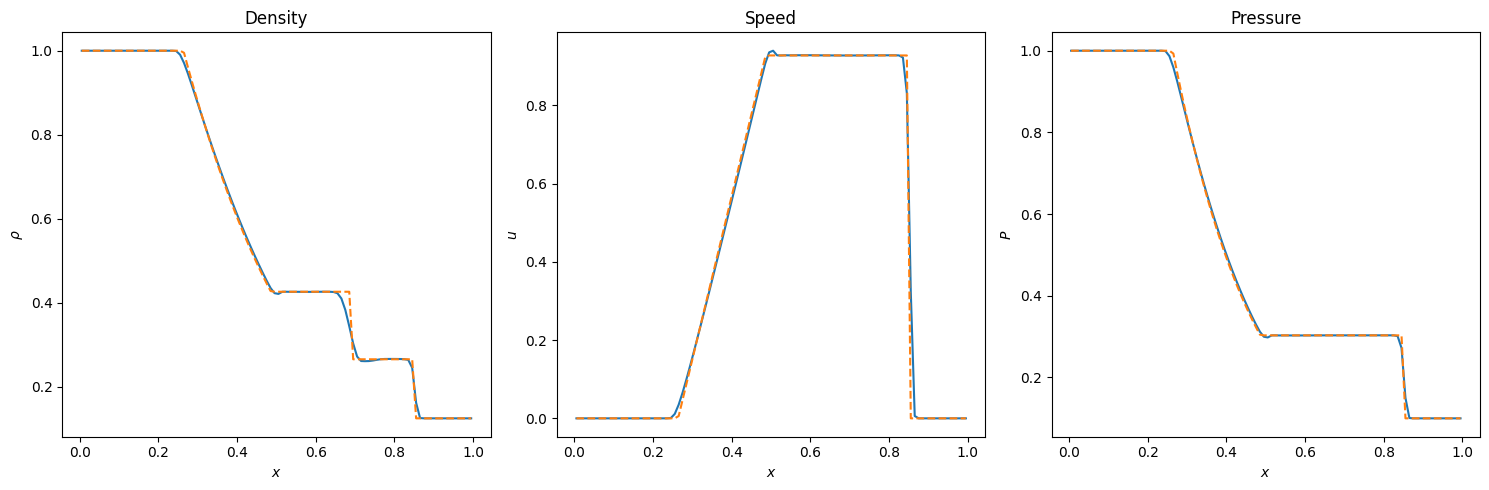

In [126]:
evolve(prob='sod', dx_type='MUSCL', dt_type='RK2', N=100, refine_epsilon=np.inf, coarse_epsilon=np.inf, solve_method='new', plot=True)

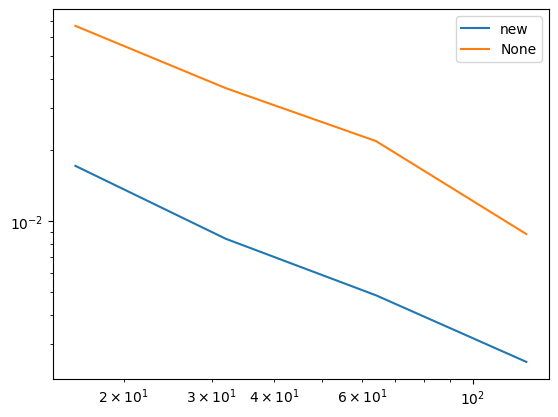

In [111]:
plt.loglog(N, sod_MSE['new']['MUSCL'], label='new')
plt.loglog(N, sod_MSE['None']['MUSCL'], label='None')
plt.legend()

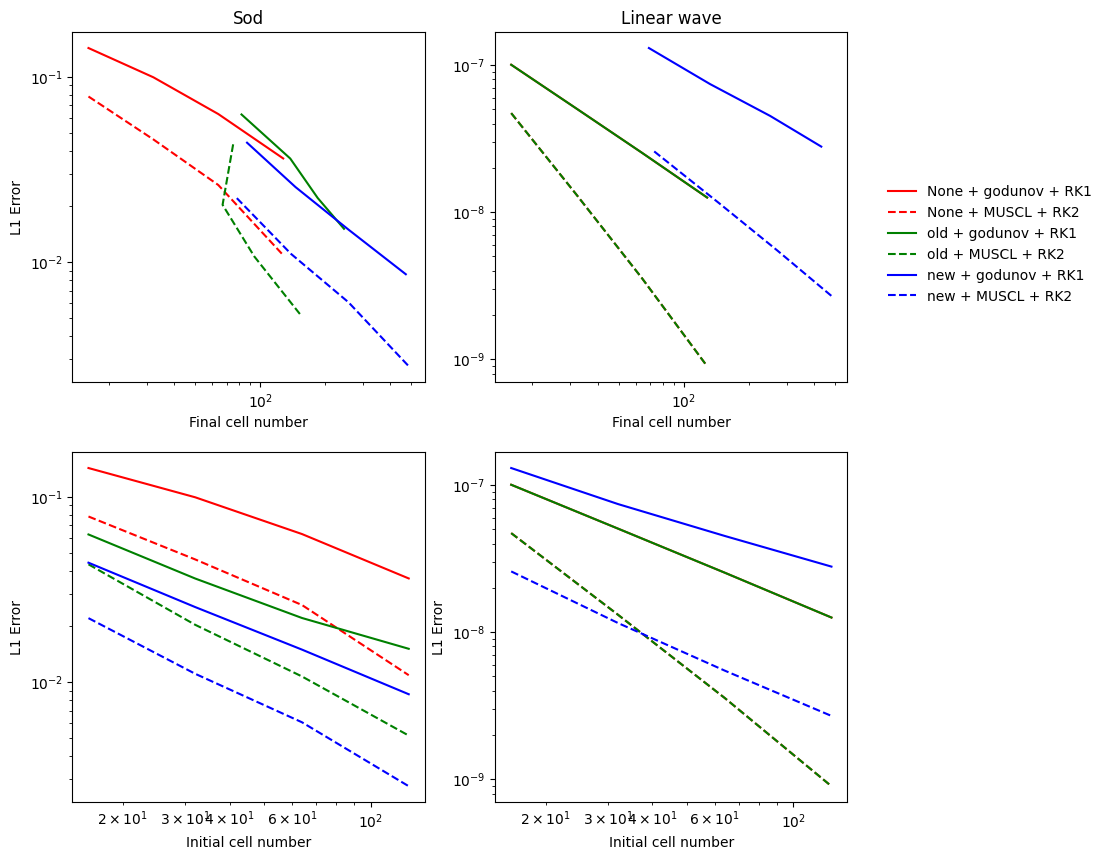

In [164]:
# Forced no refinement
fig, ax = plt.subplots(2, 2, figsize=(10,10))
compare(ax[0][0], sod_final_gridm, sod_MSE, xlabel='Final cell number', ylabel='L1 Error', title='Sod')
compare(ax[0][1], plane_final_grid, plane_MSE, xlabel='Final cell number', title='Linear wave', legend=True)
compare(ax[1][0], N_dict, sod_MSE, xlabel='Initial cell number', ylabel='L1 Error', )
compare(ax[1][1], N_dict, plane_MSE, xlabel='Initial cell number', ylabel='L1 Error', )
#plt.tight_layout()

# Some reflection:
- higher final cell number $\neq$ worse algorithm? as original aim is to refine where refinement is required but not found? -> but also it should althought it didn't...
- Forced no refinement in old and new methods. Old performs better in godunov, while new performs better in MUSCL -> averaging difference in order?
- doing linear wave new method don't refine works better than refinement?

# ???
- any systematic error calculation comparison in AMR?
- may be some are better in smooth and some are better in shock
- shock-detector change error detection and algorithm?